# Prädiktion der Bauteilqualität aus Maschinenparametern

Ziel ist es ein statisches polynomiales Modell zu bestimmen, welches die eingestellen Maschinenparameter auf die resultierende Bauteilqualität abbildet. 

Die für das Modelltraining (Schätzung der Modellparameter) und die Modellvalidierung zu verwendenden Daten wurden im Rahmen eines umfangreichen Versuchsplanes erhoben. Der Trainingsdatensatz umfasst die Daten von 2105 Produktionszyklen, der Validierungsdatensatz umfasst die Daten von 548 Produktionszyklen

In [1]:
import casadi as cs
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data_train = pkl.load(open('./data/setpoint_data_train.pkl','rb'))
data_val= pkl.load(open('./data/setpoint_data_val.pkl','rb'))

Plotte Ausgangsgröße (Bauteilqualität) des Trainings- und Validierungsdatensatzes

(1.0, 40.0)

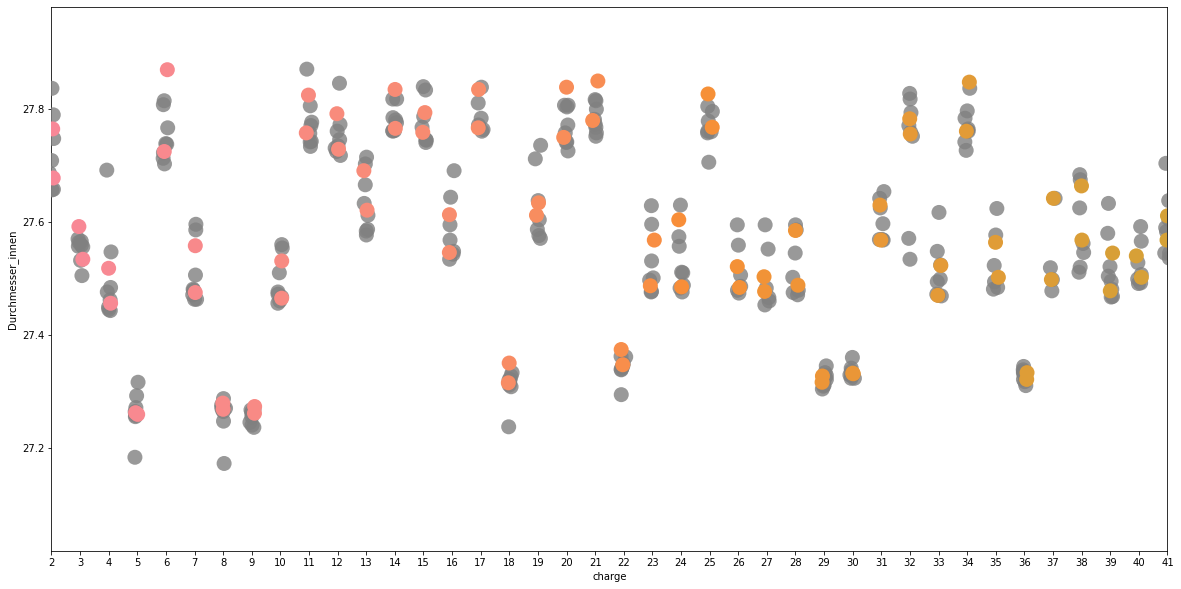

In [3]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.stripplot(x=data_train['charge'],y=data_train['Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)
sns.stripplot(x=data_val['charge'],y=data_val['Durchmesser_innen'],size=15,ax=ax)
ax.set_xlim([1,40]) # Zeige nur Teil des Plots da man sonst nicht viel erkennen kann 

Definiere zu identifizierendes Modell as CasADi-Funktion

In [4]:
theta0 = cs.MX.sym('theta',1,1)
theta1 = cs.MX.sym('theta',8,1)
theta2 = cs.MX.sym('theta',36,1)

theta = cs.vcat([theta0,theta1,theta2])

u = cs.MX.sym('u',8,1)

interact = cs.mtimes(u,u.T)                       # Erhalte quadratische und Interaktionsterme durch u u'
interact = [interact[i:,i] for i in range(0,8)]   # Wähle obere Dreiecksmatrix
interact = cs.vcat(interact)                      # Forme um in einen Vektor

y = theta0 + cs.mtimes(theta1.T,u) + cs.mtimes(theta2.T,interact)

f_model = cs.Function('f_model',[u,theta],[y],['u','theta'],['y'])

Werte Modell auf den Trainingsdaten aus und baue die Kostenfunktion auf

In [5]:
L = 0

u_label=['Düsentemperatur', 'Werkzeugtemperatur', 'Einspritzgeschwindigkeit',
       'Umschaltpunkt', 'Nachdruckhöhe', 'Nachdruckzeit', 'Staudruck',
       'Kühlzeit']

y_label = ['Durchmesser_innen']

for k in data_train.index:
    u_k = data_train.loc[k][u_label].values.reshape((8,1))
    
    y_k = data_train.loc[k][y_label]
    
    y_hat = f_model(u=u_k, theta=theta)['y']
    L = L + 0.5*(y_hat - y_k)**2

In [6]:
qp = {'x':theta, 'f':L}
S = cs.qpsol('S', 'qpoases', qp)
r=S()

theta_opt = r['x']



#################   qpOASES  --  QP NO.   1   ##################

    Iter   |    StepLength    |       Info       |   nFX    
 ----------+------------------+------------------+--------- 
       0   |   0.000000e+000   |   REM BND    0   |    44   
       1   |   5.965321e-020   |   REM BND   35   |    43   
       2   |   7.249005e-019   |   REM BND   37   |    42   
       3   |   1.693629e-018   |   REM BND   26   |    41   
       4   |   1.293076e-017   |   REM BND   13   |    40   
       5   |   1.673658e-017   |   REM BND   20   |    39   
       6   |   8.080040e-017   |   REM BND   38   |    38   
       7   |   3.308844e-016   |   REM BND   15   |    37   
       8   |   1.772395e-016   |   REM BND   36   |    36   
       9   |   8.310436e-016   |   REM BND   11   |    35   
      10   |   5.378711e-016   |   REM BND   28   |    34   
      11   |   4.345350e-016   |   REM BND    9   |    33   
      12   |   2.197520e-016   |   REM BND   31   |    32   
      13   |   4.

In [7]:
y_hat = []

for k in data_train.index:
    u_k = data_train.loc[k][u_label].values.reshape((8,1))
    
    y_k = data_train.loc[k][y_label]
    
    y_hat.append(float(f_model(u=u_k, theta=theta_opt)['y']))
    
data_train = data_train.assign(y_hat=y_hat)

R_train = 1 - sum((data_train[y_label[0]]-data_train['y_hat'])**2)/sum((data_train[y_label[0]]-data_train[y_label[0]].mean())**2)

print('Bestimmheitsmaß auf den Trainingsdaten: '+str(R_train))

Bestimmheitsmaß auf den Trainingsdaten: 0.7503402141341883


In [8]:
y_hat = []

for k in data_val.index:
    u_k = data_val.loc[k][u_label].values.reshape((8,1))
    
    y_k = data_val.loc[k][y_label]
    
    y_hat.append(float(f_model(u=u_k, theta=theta_opt)['y']))
    
data_val = data_val.assign(y_hat=y_hat)

R_val = 1 - sum((data_val[y_label[0]]-data_val['y_hat'])**2)/sum((data_val[y_label[0]]-data_val[y_label[0]].mean())**2)

print('Bestimmheitsmaß auf den Validierungsdaten: '+str(R_train))

Bestimmheitsmaß auf den Validierungsdaten: 0.7503402141341883


(1.0, 50.0)

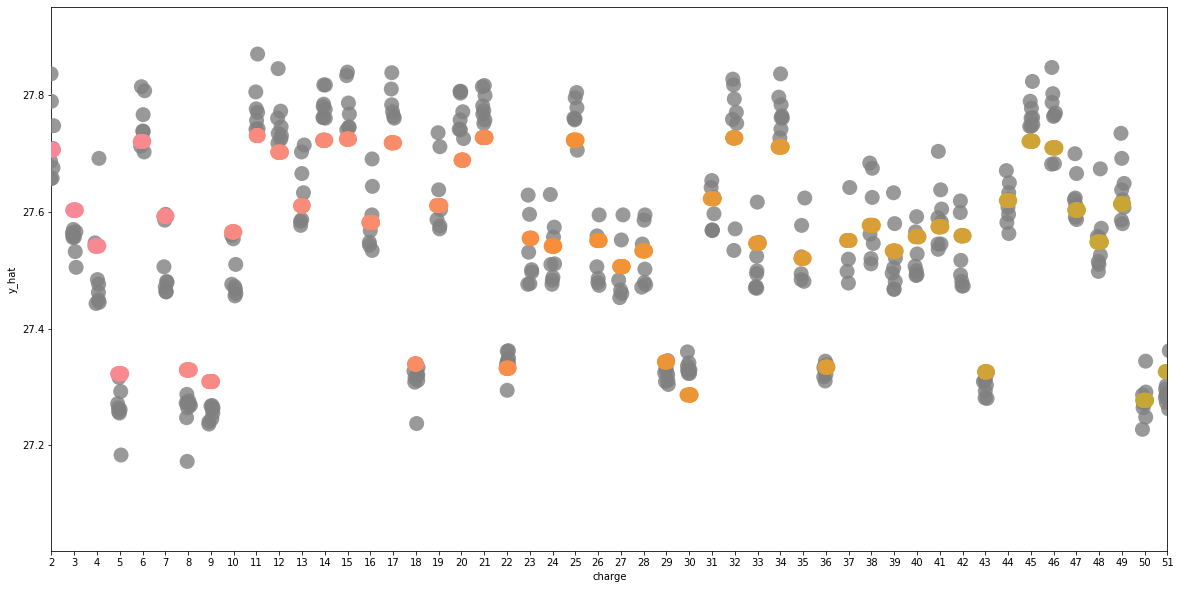

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.stripplot(x=data_train['charge'],y=data_train['Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)
sns.stripplot(x=data_train['charge'],y=data_train['y_hat'],size=15,ax=ax)
ax.set_xlim([1,50]) # Zeige nur Teil des Plots da man sonst nicht viel erkennen kann



(1.0, 50.0)

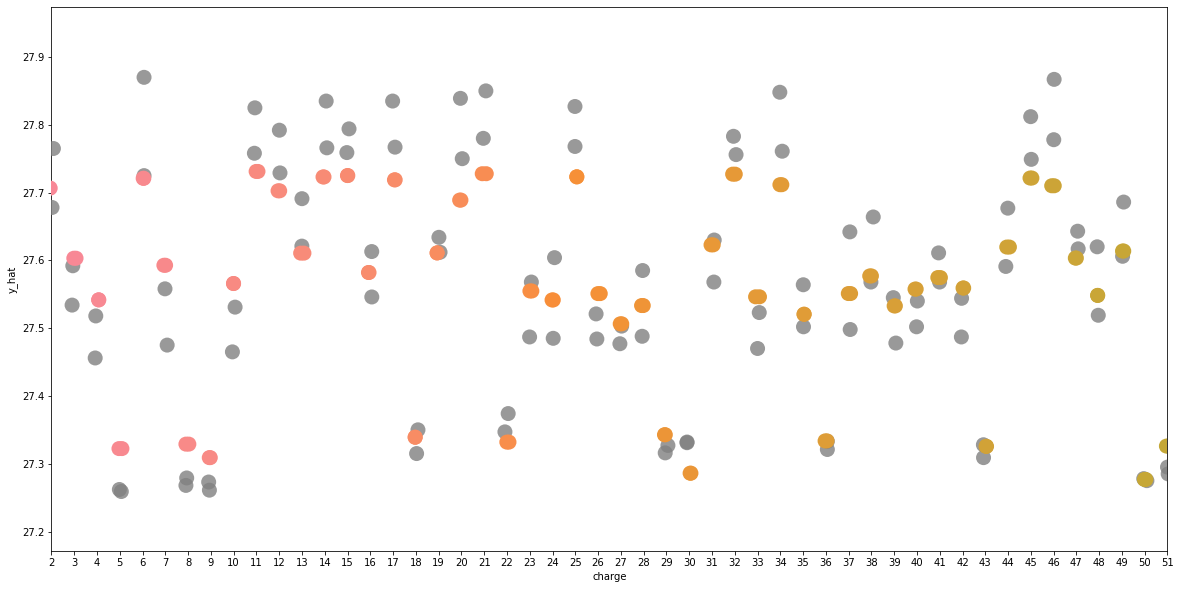

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.stripplot(x=data_val['charge'],y=data_val['Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)
sns.stripplot(x=data_val['charge'],y=data_val['y_hat'],size=15,ax=ax)
ax.set_xlim([1,50]) # Zeige nur Teil des Plots da man sonst nicht viel erkennen kann

Zyklusnummer
11      27.351
12      27.309
14      27.307
15      27.313
16      27.279
         ...  
2777    27.744
2778    27.720
2780    27.691
2781    27.684
2782    27.681
Name: Durchmesser_innen, Length: 2104, dtype: float64

0.7503402141341883

3.185007813044649e-10

27.65650095057039